In [3]:
import scipy
import numpy as np
import pandas as pd

# Условие
Исследуется заработная плата работников с одинаковой квалификацией на предприятиях одной отрасли. С этой целью были проведены четыре выборки среди предприятий отрасли. Результаты представлены в таблицах  19 –22. Для предприятий этой отрасли была установлена средняя заработная плата 22 500 руб. 

По результатам  проведённого статистического анализа ответьте на вопросы:

* Можно ли считать, что заработная плата на предприятии соответствует установленному уровню?
* Сравните полученные выборочные с данными другого предприятия отрасли (по выбору).  Можно ли сказать, что работники этих предприятий получают одинаковое вознаграждение?
* Насколько нужно увеличить объём  выборки, чтобы точность оценки увеличились на 15%?

In [4]:
# Таблица 20
x20 = np.array([14600, 22700, 23600, 24600, 24700, 25400, 25550, 26550, 27400])
n20 = np.array([1, 4, 5, 6, 7, 2, 4, 1, 3])

# Приведем данные в удобный для python вид
data20 = []
for salary, num_employ in zip(x20, n20):
    data20 += [salary] * num_employ

data20 = np.array(data20)
print(data20)

[14600 22700 22700 22700 22700 23600 23600 23600 23600 23600 24600 24600
 24600 24600 24600 24600 24700 24700 24700 24700 24700 24700 24700 25400
 25400 25550 25550 25550 25550 26550 27400 27400 27400]


# EDA

Среднее - 24413.636363636364
Медиана - 24700.0
Вариация - 4562920.110192837
Эксцесса - 10.943120867903607
Ассиметрия - -2.7057851970137663


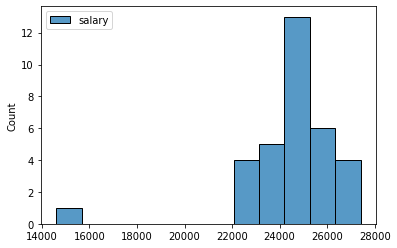

In [5]:
from scipy.stats import kurtosis, skew
import seaborn as sns


print(f'Среднее - {data20.mean()}')
print(f'Медиана - {np.median(data20)}')
print(f'Вариация - {data20.var()}')
print(f'Эксцесса - {kurtosis(data20)}')
print(f'Ассиметрия - {skew(data20)}')

sns.histplot(pd.DataFrame(data20, columns=['salary']));

# Проверка на нормальность
Давайте проеведем тест Шапиро-Уилка

In [6]:
from scipy.stats import shapiro
# H0 - данные пришли из нормального распределения
# H1 - это не так

print(f'p-value = {shapiro(data20).pvalue}. Отклоняем нулевую гипотезу о нормальности')

p-value = 1.066740423993906e-06. Отклоняем нулевую гипотезу о нормальности


# Построение доверительных интервалов

По ЦПТ при существовании дисперсии распределения оценка

$$\sqrt{n} \frac{\bar{X}_{n}-\mu}{\sigma} \rightarrow N(0,1), \text { по распределению при } n \rightarrow \infty,
$$

где $\bar{X}_n$ среднее арифметическое, $\mu$ - мат ожидание, $\sigma^2$ - дисперсия. Мы можем заменить $\sigma$ на стандартное отклонение, так как стандартное отклонение есть состоятельная оценка $\sigma$ и асимптотическая нормальность не изменится. Отсюда мы можем получить асимптотический доверительный интервал уровня $\gamma$

$$\bar{X}-\frac{z_{\frac{1+\gamma}{2}} \bar s}{\sqrt{n}}<a<\bar{X}+ \frac{z_{\frac{1+\gamma}{2}} \bar s}{\sqrt{n}}$$

In [7]:
from scipy.stats import norm

def confidence_interval(data, gamma):
    mean = np.mean(data)
    std = np.std(data)
    border = norm.ppf((1 + gamma) / 2) * std / np.sqrt(len(data))
    return mean - border, mean + border

In [8]:
# Мы видим, что ожидаемая средняя зараплата не лежит в 99-ти процентном доверительном интервале, 
# то есть заработная плата на предприятии  не соответствует установленному уровню. 

print('Доверительный интервал для мат ожидания:', confidence_interval(data20, 0.99))

Доверительный интервал для мат ожидания: (23455.8215664271, 25371.451160845627)


Так же построим доверительный интервал для среднего в смысле медианы.
Возьмем вариацонный ряд из наших наблюдений –
$X_{[1]}, X_{[2]}, X_{[3]} , ..., X_{[n]}$
Наши наблюдения, как реализация случайных величин, могли попасть слева от медианы и справа от медины с вероятностью $p = \frac{1}{2}$.
$$
P\left(X_{j} \leq median \leq X_{k}\right)=\sum_{i=j}^{k}\left( C_{n}^i\right)\left(p^{i}\right)(1-p)^{n-i}
$$
Найдем при каких i, k эта вероятность больше 99 

In [9]:
# Находим i, k
from scipy.stats import binom

n, p = len(data20), 1/2
i, k = binom.interval(0.99, n, p)
sorted_data20 = np.sort(data20)
print(f'Доверительный интервал для медианы: {sorted_data20[int(i)], sorted_data20[int(k)]}')

Доверительный интервал для медианы: (23600, 25400)


Сравним этот доверительный интервал для с доверительный интервалом, полученный с помощью bootstrap

In [10]:
def bootstrap(data, num_samples, statistic, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha / 2.0) * num_samples)],
            stat[int((1 - alpha / 2.0) * num_samples)])

low, high = bootstrap(data20, 10000, np.median, 0.01)
print(f'Доверительный интервал для медианы(bootstrap): {low, high}')

Доверительный интервал для медианы(bootstrap): (23600.0, 25400.0)


Ого! Они совпали! Видим, что все эти интервалы не содержат 22 500

# Проверка статистических гипотез

In [11]:
from scipy.stats import wilcoxon

# H0: med X = mo
wilcoxon(data20 - 22_500)

WilcoxonResult(statistic=33.0, pvalue=9.23558212695375e-06)

Отвергаем нулевую гипотезу при уровне значимости 0.005. Среднее в смысле медианы не равно 22 500

# Сравнение с другим предприятием

Для оценивания средних зарплат 2ух предприятий будем использовать критерий равенства медиан, потому что она лучше оценивает среднее в случае зарплат (не сильно реагирует на выбросы).

In [12]:
x21 = np.array([21750, 21800, 22100, 22200, 22900, 23100, 24550, 25500, 25600])
n21 = np.array([1, 3, 3, 5, 6, 3, 2, 1, 1])

data21 = []
for salary, num_employ in zip(x21, n21):
    data21 += [salary] * num_employ

data21 = np.array(data21)
print(data21)

[21750 21800 21800 21800 22100 22100 22100 22200 22200 22200 22200 22200
 22900 22900 22900 22900 22900 22900 23100 23100 23100 24550 24550 25500
 25600]


In [13]:
# Так же сделаем доверительный интервал для медианы.

low, high = bootstrap(data21, 100000, np.median, 0.01)
print(f'Доверительный интервал для медианы(bootstrap): {low, high}')

Доверительный интервал для медианы(bootstrap): (22100.0, 23100.0)


In [14]:
# Доверительный интервал для среднего арифметического зарплат 21 цеха. 

confidence_interval(data21, 0.99)

(22300.254449246793, 23407.745550753207)

In [15]:
# H0: med X = mo
wilcoxon(data21 - 22_500) # нет оснований отклонить нулевую гипотезу

WilcoxonResult(statistic=123.0, pvalue=0.2996123433113098)

In [16]:
from tqdm.auto import tqdm

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [17]:
get_bootstrap(pd.DataFrame(data20), pd.DataFrame(data21), bootstrap_conf_level=0.99)['p_value']

2.0493435819638607e-07

Отвергаем нулевую гипотезу при уровне значимости 0.005. Средние в смысле медианы не равны.